In [1]:
import pandas as pd
import numpy as np 
import fasttext as ft 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import label_binarize, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_classif, f_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from collections import Counter
import os 

In [6]:
def column_adjustor(dataset_column):
    codes, uniques = pd.factorize(dataset_column)
    return pd.Series(codes, index=dataset_column.index)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.773 total time=   9.6s
[CV 2/5] END .............................C=0.1;, score=0.774 total time=   5.0s
[CV 3/5] END .............................C=0.1;, score=0.771 total time=   5.2s
[CV 4/5] END .............................C=0.1;, score=0.769 total time=   5.3s
[CV 5/5] END .............................C=0.1;, score=0.771 total time=   5.5s
[CV 1/5] END ...............................C=1;, score=0.776 total time=  10.6s
[CV 2/5] END ...............................C=1;, score=0.776 total time=   9.7s
[CV 3/5] END ...............................C=1;, score=0.773 total time=  10.0s
[CV 4/5] END ...............................C=1;, score=0.772 total time=   9.9s
[CV 5/5] END ...............................C=1;, score=0.773 total time=  10.5s
[CV 1/5] END ..............................C=10;, score=0.777 total time=  17.3s
[CV 2/5] END ..............................C=10;,

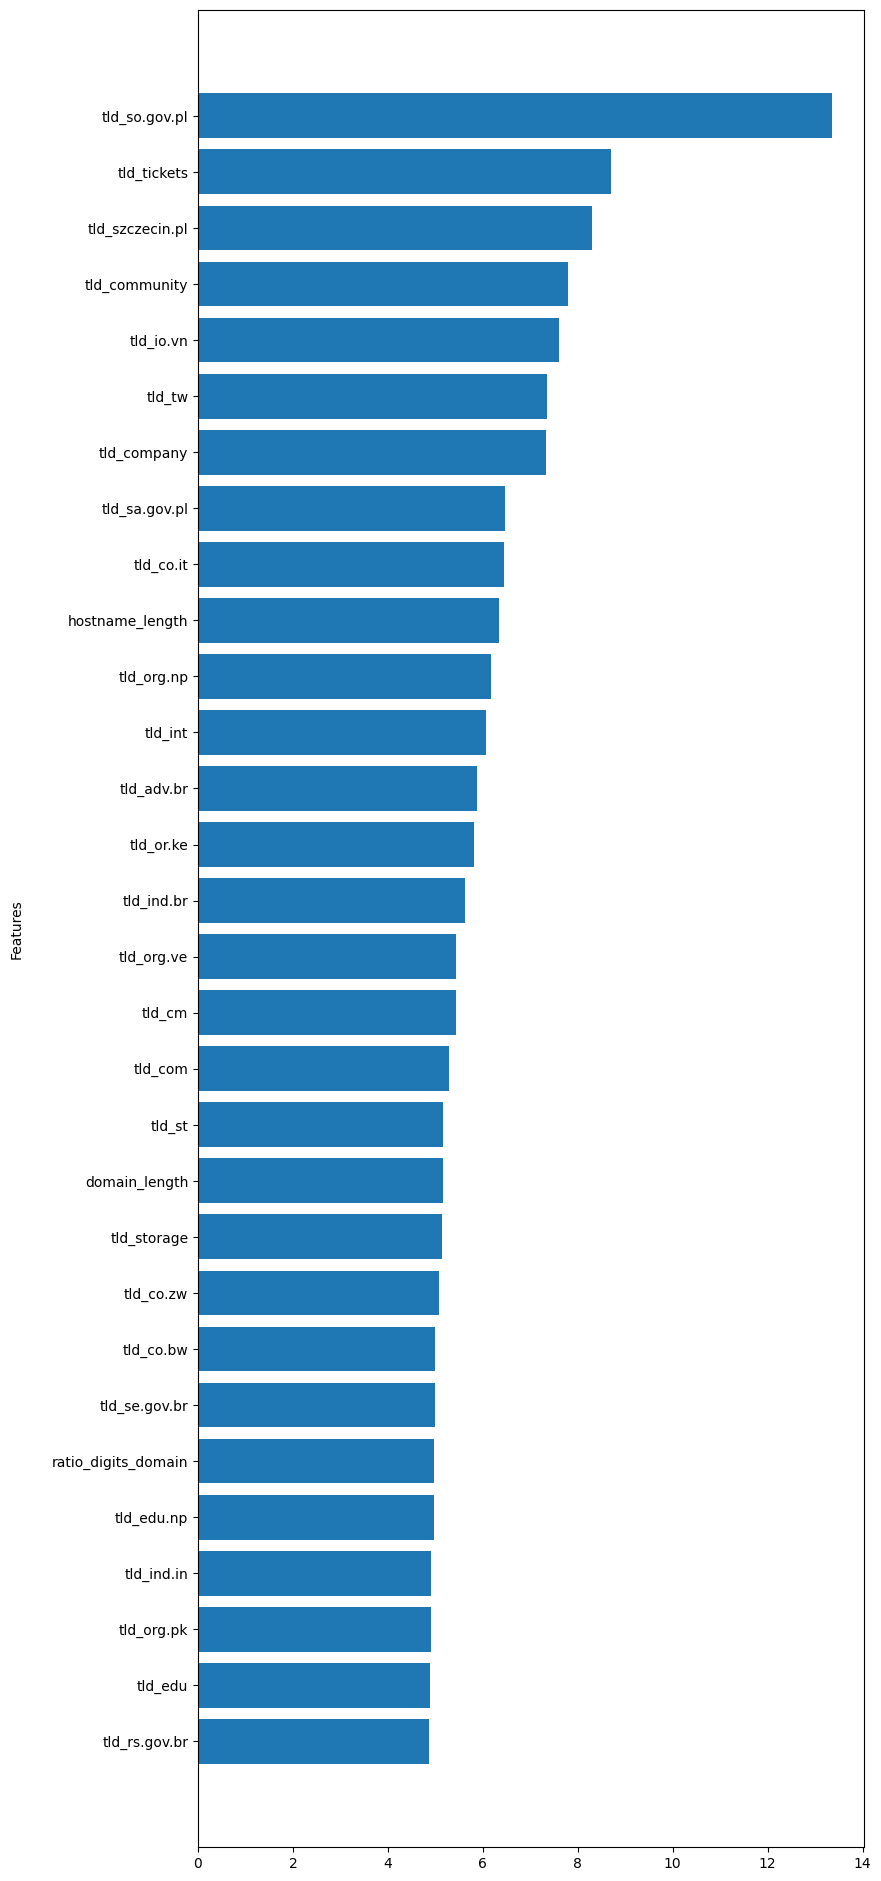

In [2]:
INPUT_FILE = "base_features.csv"
OUTPUT_GRAPH_FILE = "logistic_regression_base_features.png"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

def get_top_n(string, n):
    return ' '.join([tup[0] for tup in Counter(' '.join(string.splitlines())).most_common(n)])

def len_skip_na(s):
    if type(s) != str:
        return 0
    return len(s)

ft_model = ft.load_model('./wiki.en.bin')
cols_to_vectorize = []
cols_to_binarize = []
cols_to_categorize = ['tld']
cols_to_omit = ['label', 'url']
LONG_THRESHOLD = 50

new_df = pd.DataFrame()

for colname in df.columns:
    if colname in cols_to_vectorize:
        arr = [np.mean(ft_model.get_sentence_vector(' '.join(value.splitlines()))) if not pd.isna(value) else pd.NA for value in df[colname]]
        arr = np.array(arr)
        new_df[colname] = arr
    elif colname in cols_to_binarize:
        new_df[colname] = label_binarize(df[colname], classes=pd.unique(df[colname]))
    else:
        if colname not in cols_to_omit:
            new_df[colname] = df[colname].values

X = new_df
X['tld'] = X['tld'].astype(str).fillna("Unknown")
X = X.fillna(-1)
y = df['label'].astype(float)
target = y 

numeric_cols = [col for col in new_df.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X_transformed = preprocessor.fit_transform(X)
X_transformed = X_transformed
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=42)

parameters = {'C': [0.1, 1, 10]}
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
clf = GridSearchCV(lr, parameters, verbose=3)
clf.fit(X_train, y_train)
lr = clf.best_estimator_

coef = lr.coef_[0]
f_i = list(zip(features, np.abs(coef)))
f_i.sort(key=lambda x : x[1])
f_i = f_i[-31:-1]
plt.figure(figsize=(10, 20))
plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.ylabel("Features", labelpad=20)
plt.tight_layout(pad = 5.0)
plt.savefig(OUTPUT_GRAPH_FILE)
selected_features = [feature[0] for feature in f_i]
print(f"Selected Features: {str(selected_features)}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.793 total time=   6.8s
[CV 2/5] END .............................C=0.1;, score=0.793 total time=   8.0s
[CV 3/5] END .............................C=0.1;, score=0.789 total time=   7.9s
[CV 4/5] END .............................C=0.1;, score=0.790 total time=   7.3s
[CV 5/5] END .............................C=0.1;, score=0.792 total time=   7.1s
[CV 1/5] END ...............................C=1;, score=0.797 total time=  13.5s
[CV 2/5] END ...............................C=1;, score=0.796 total time=  15.1s
[CV 3/5] END ...............................C=1;, score=0.793 total time=  13.9s
[CV 4/5] END ...............................C=1;, score=0.794 total time=  14.0s
[CV 5/5] END ...............................C=1;, score=0.797 total time=  14.4s
[CV 1/5] END ..............................C=10;, score=0.798 total time=  19.4s
[CV 2/5] END ..............................C=10;,

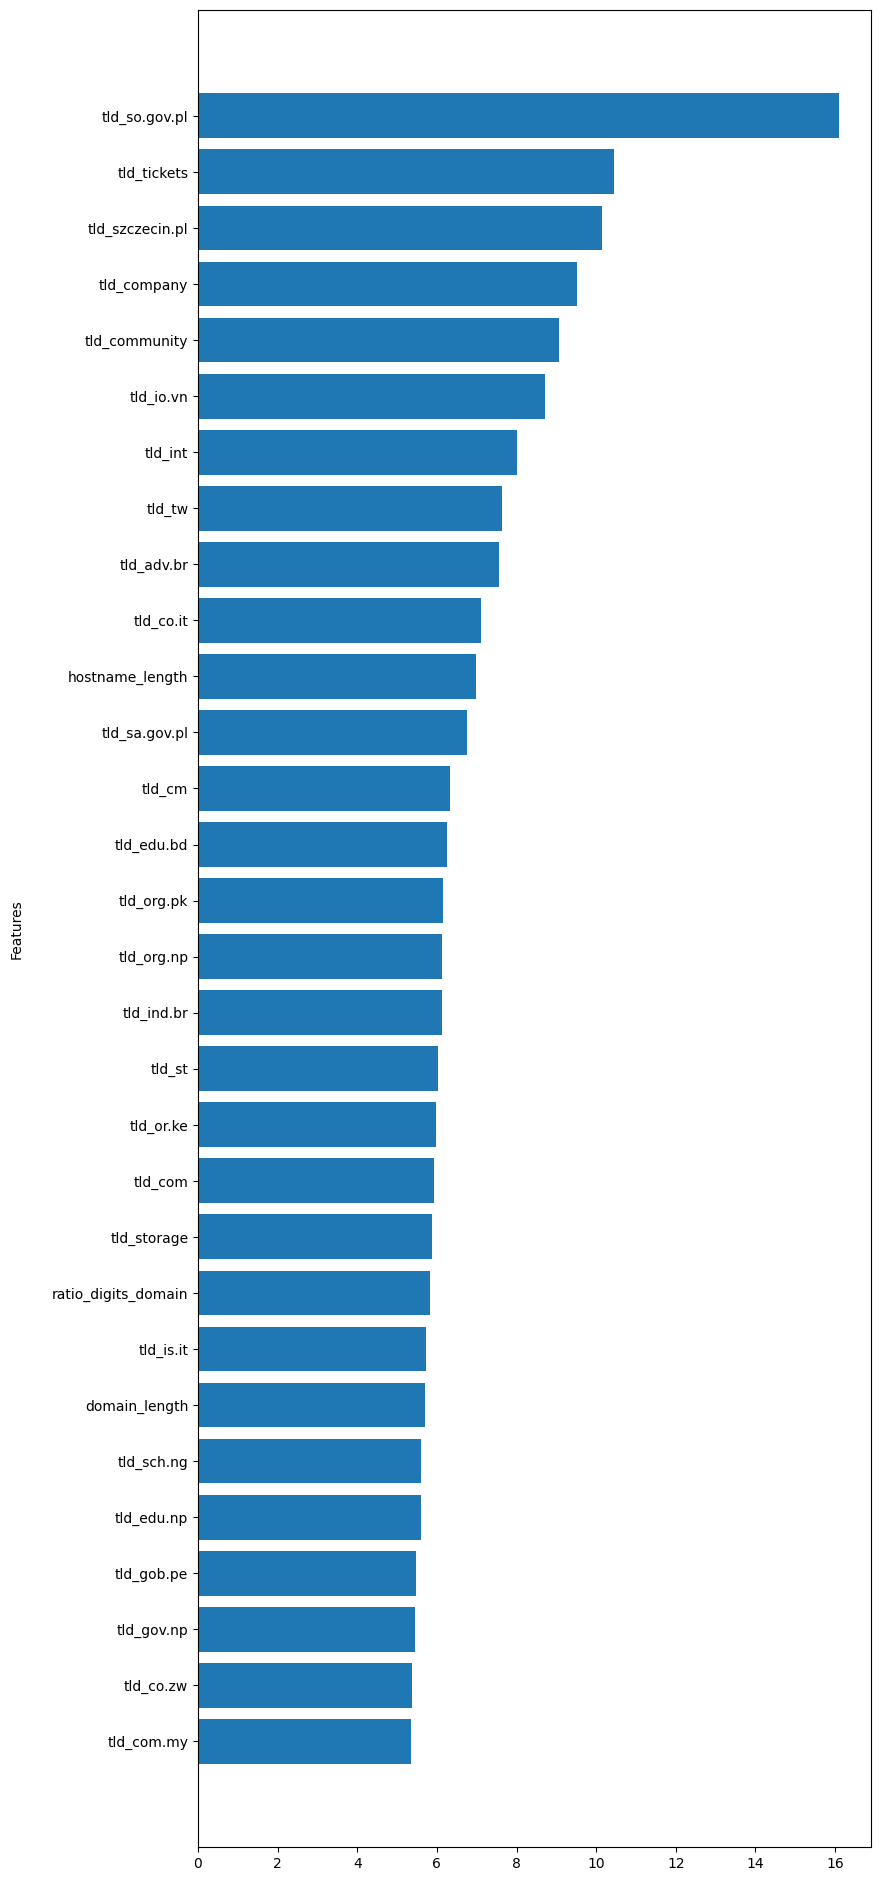

In [3]:
INPUT_FILE = "cascade_1.csv"
OUTPUT_GRAPH_FILE = "logistic_regression_cascade_1.png"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

def get_top_n(string, n):
    return ' '.join([tup[0] for tup in Counter(' '.join(string.splitlines())).most_common(n)])

def len_skip_na(s):
    if type(s) != str:
        return 0
    return len(s)

ft_model = ft.load_model('./wiki.en.bin')
cols_to_vectorize = []
cols_to_binarize = []
cols_to_categorize = ['tld']
cols_to_omit = ['label', 'url']
LONG_THRESHOLD = 50

new_df = pd.DataFrame()

for colname in df.columns:
    if colname in cols_to_vectorize:
        arr = [np.mean(ft_model.get_sentence_vector(' '.join(value.splitlines()))) if not pd.isna(value) else pd.NA for value in df[colname]]
        arr = np.array(arr)
        new_df[colname] = arr
    elif colname in cols_to_binarize:
        new_df[colname] = label_binarize(df[colname], classes=pd.unique(df[colname]))
    else:
        if colname not in cols_to_omit:
            new_df[colname] = df[colname].values

X = new_df
X['tld'] = X['tld'].astype(str).fillna("Unknown")
X = X.fillna(-1)
y = df['label'].astype(float)
target = y 

numeric_cols = [col for col in new_df.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X_transformed = preprocessor.fit_transform(X)
X_transformed = X_transformed
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=42)

parameters = {'C': [0.1, 1, 10]}
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
clf = GridSearchCV(lr, parameters, verbose=3)
clf.fit(X_train, y_train)
lr = clf.best_estimator_

coef = lr.coef_[0]
f_i = list(zip(features, np.abs(coef)))
f_i.sort(key=lambda x : x[1])
f_i = f_i[-31:-1]
plt.figure(figsize=(10, 20))
plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.ylabel("Features", labelpad=20)
plt.tight_layout(pad = 5.0)
plt.savefig(OUTPUT_GRAPH_FILE)
selected_features = [feature[0] for feature in f_i]
print(f"Selected Features: {str(selected_features)}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.863 total time=   7.8s
[CV 2/5] END .............................C=0.1;, score=0.862 total time=   8.7s
[CV 3/5] END .............................C=0.1;, score=0.864 total time=   8.6s
[CV 4/5] END .............................C=0.1;, score=0.862 total time=   7.8s
[CV 5/5] END .............................C=0.1;, score=0.864 total time=   9.3s
[CV 1/5] END ...............................C=1;, score=0.867 total time=  16.6s
[CV 2/5] END ...............................C=1;, score=0.866 total time=  21.2s
[CV 3/5] END ...............................C=1;, score=0.868 total time=  18.5s
[CV 4/5] END ...............................C=1;, score=0.865 total time=  18.4s
[CV 5/5] END ...............................C=1;, score=0.868 total time=  19.2s
[CV 1/5] END ..............................C=10;, score=0.868 total time=  25.4s
[CV 2/5] END ..............................C=10;,

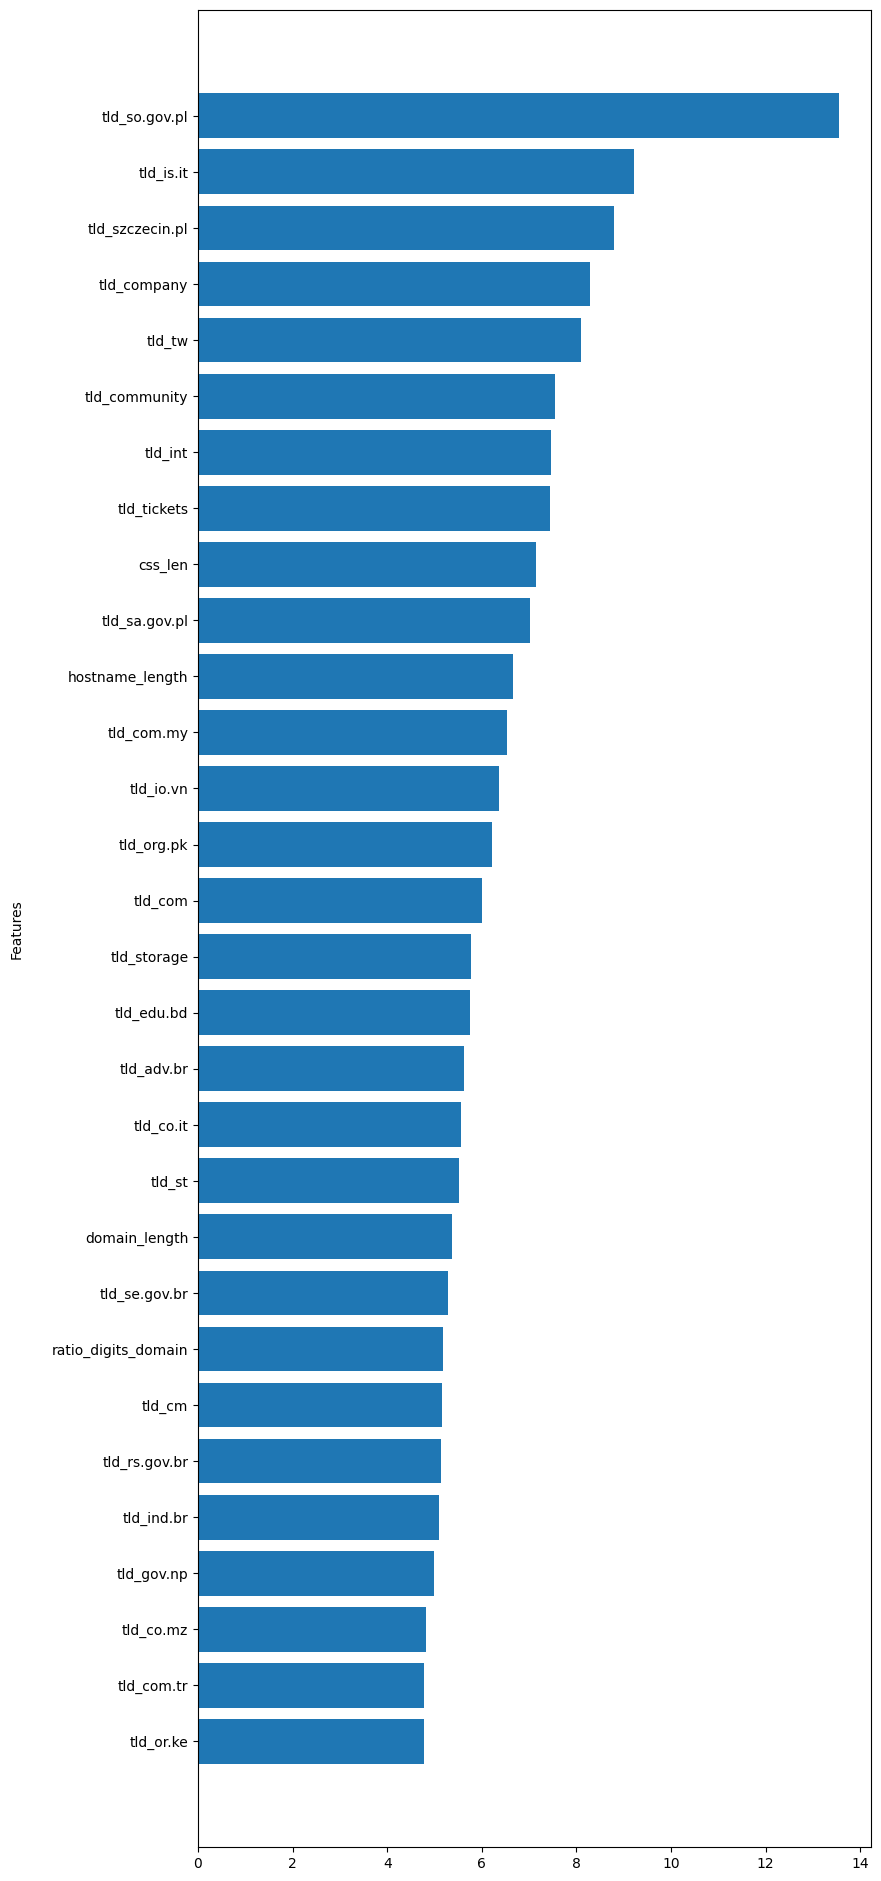

In [4]:
INPUT_FILE = "cascade_2.csv"
OUTPUT_GRAPH_FILE = "logistic_regression_cascade_2.png"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

def get_top_n(string, n):
    return ' '.join([tup[0] for tup in Counter(' '.join(string.splitlines())).most_common(n)])

def len_skip_na(s):
    if type(s) != str:
        return 0
    return len(s)

ft_model = ft.load_model('./wiki.en.bin')
cols_to_vectorize = []
cols_to_binarize = []
cols_to_categorize = ['tld']
cols_to_omit = ['label', 'url']
LONG_THRESHOLD = 50

new_df = pd.DataFrame()

for colname in df.columns:
    if colname in cols_to_vectorize:
        arr = [np.mean(ft_model.get_sentence_vector(' '.join(value.splitlines()))) if not pd.isna(value) else pd.NA for value in df[colname]]
        arr = np.array(arr)
        new_df[colname] = arr
    elif colname in cols_to_binarize:
        new_df[colname] = label_binarize(df[colname], classes=pd.unique(df[colname]))
    else:
        if colname not in cols_to_omit:
            new_df[colname] = df[colname].values

X = new_df
X['tld'] = X['tld'].astype(str).fillna("Unknown")
X = X.fillna(-1)
y = df['label'].astype(float)
target = y 

numeric_cols = [col for col in new_df.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X_transformed = preprocessor.fit_transform(X)
X_transformed = X_transformed
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=42)

parameters = {'C': [0.1, 1, 10]}
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
clf = GridSearchCV(lr, parameters, verbose=3)
clf.fit(X_train, y_train)
lr = clf.best_estimator_

coef = lr.coef_[0]
f_i = list(zip(features, np.abs(coef)))
f_i.sort(key=lambda x : x[1])
f_i = f_i[-31:-1]
plt.figure(figsize=(10, 20))
plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.ylabel("Features", labelpad=20)
plt.tight_layout(pad = 5.0)
plt.savefig(OUTPUT_GRAPH_FILE)
selected_features = [feature[0] for feature in f_i]
print(f"Selected Features: {str(selected_features)}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.870 total time=  14.1s
[CV 2/5] END .............................C=0.1;, score=0.871 total time=  12.5s
[CV 3/5] END .............................C=0.1;, score=0.871 total time=  12.8s
[CV 4/5] END .............................C=0.1;, score=0.870 total time=  13.5s
[CV 5/5] END .............................C=0.1;, score=0.873 total time=  14.2s
[CV 1/5] END ...............................C=1;, score=0.875 total time=  24.9s
[CV 2/5] END ...............................C=1;, score=0.875 total time=  29.0s
[CV 3/5] END ...............................C=1;, score=0.875 total time=  21.0s
[CV 4/5] END ...............................C=1;, score=0.874 total time=  21.5s
[CV 5/5] END ...............................C=1;, score=0.877 total time=  17.0s
[CV 1/5] END ..............................C=10;, score=0.876 total time=  28.4s
[CV 2/5] END ..............................C=10;,

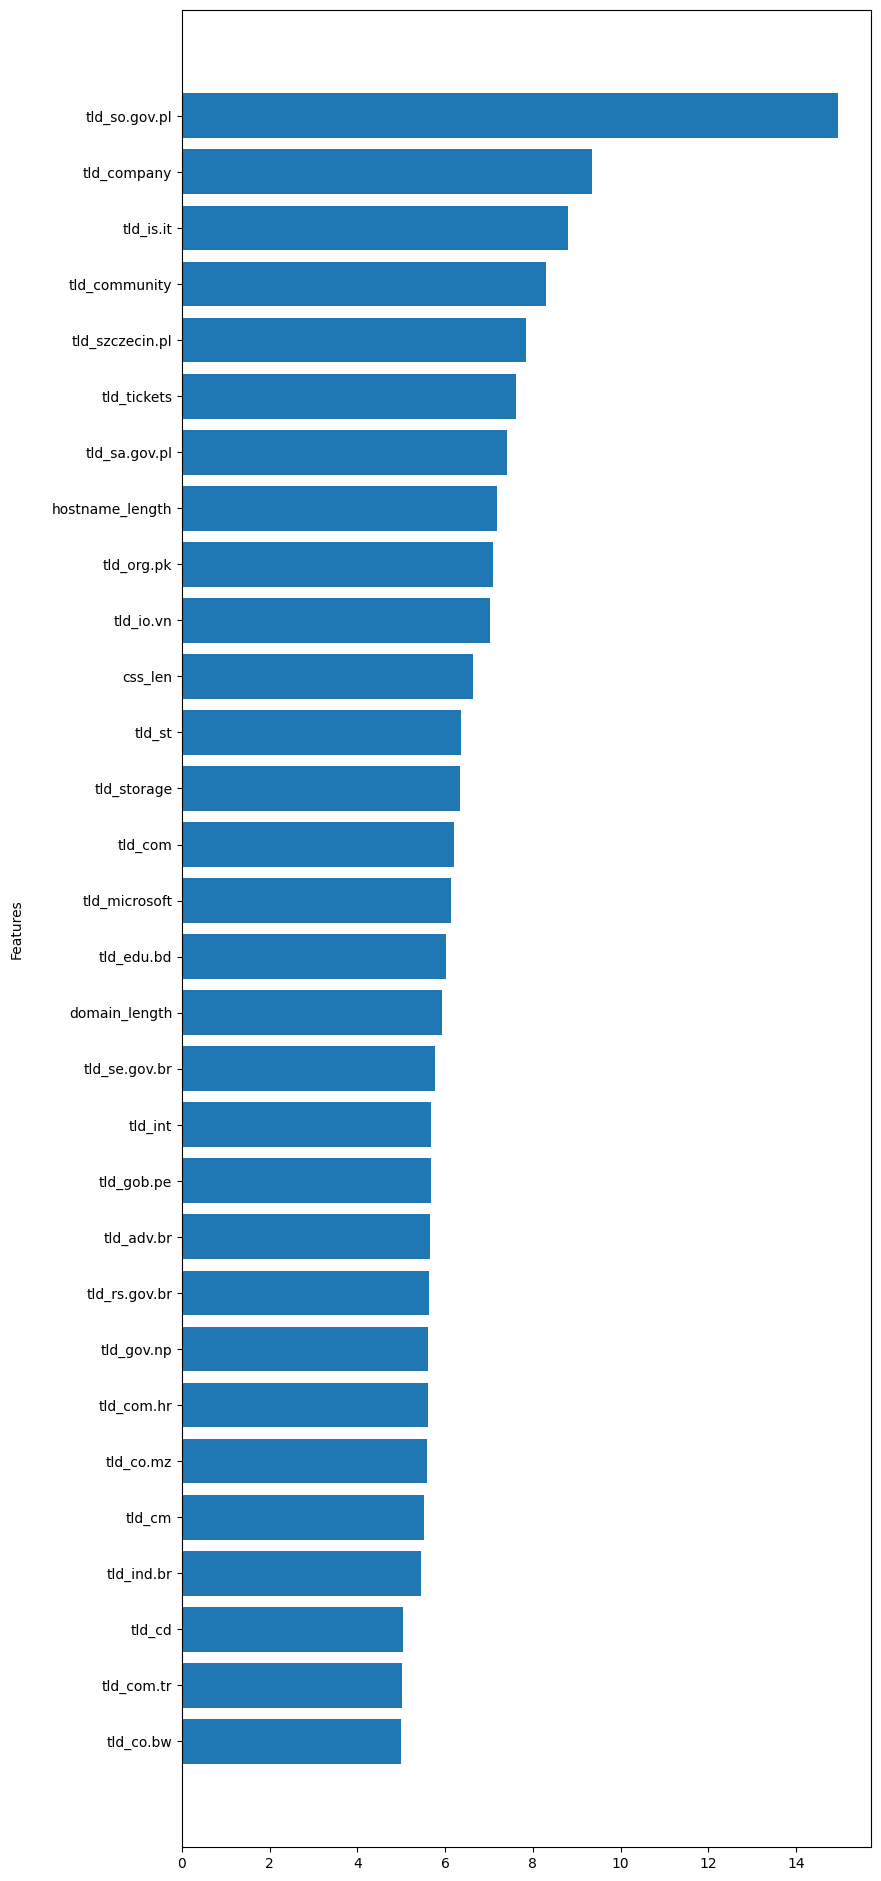

In [5]:
INPUT_FILE = "cascade_3.csv"
OUTPUT_GRAPH_FILE = "logistic_regression_cascade_3.png"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

def get_top_n(string, n):
    return ' '.join([tup[0] for tup in Counter(' '.join(string.splitlines())).most_common(n)])

def len_skip_na(s):
    if type(s) != str:
        return 0
    return len(s)

ft_model = ft.load_model('./wiki.en.bin')
cols_to_vectorize = []
cols_to_binarize = []
cols_to_categorize = ['tld']
cols_to_omit = ['label', 'url']
LONG_THRESHOLD = 50

new_df = pd.DataFrame()

for colname in df.columns:
    if colname in cols_to_vectorize:
        arr = [np.mean(ft_model.get_sentence_vector(' '.join(value.splitlines()))) if not pd.isna(value) else pd.NA for value in df[colname]]
        arr = np.array(arr)
        new_df[colname] = arr
    elif colname in cols_to_binarize:
        new_df[colname] = label_binarize(df[colname], classes=pd.unique(df[colname]))
    else:
        if colname not in cols_to_omit:
            new_df[colname] = df[colname].values

X = new_df
X['tld'] = X['tld'].astype(str).fillna("Unknown")
X = X.fillna(-1)
y = df['label'].astype(float)
target = y 

numeric_cols = [col for col in new_df.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X_transformed = preprocessor.fit_transform(X)
X_transformed = X_transformed
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=42)

parameters = {'C': [0.1, 1, 10]}
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
clf = GridSearchCV(lr, parameters, verbose=3)
clf.fit(X_train, y_train)
lr = clf.best_estimator_

coef = lr.coef_[0]
f_i = list(zip(features, np.abs(coef)))
f_i.sort(key=lambda x : x[1])
f_i = f_i[-31:-1]
plt.figure(figsize=(10, 20))
plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.ylabel("Features", labelpad=20)
plt.tight_layout(pad = 5.0)
plt.savefig(OUTPUT_GRAPH_FILE)
selected_features = [feature[0] for feature in f_i]
print(f"Selected Features: {str(selected_features)}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.878 total time=  11.3s
[CV 2/5] END .............................C=0.1;, score=0.878 total time= 1.2min
[CV 3/5] END .............................C=0.1;, score=0.878 total time= 1.6min
[CV 4/5] END .............................C=0.1;, score=0.877 total time= 2.2min
[CV 5/5] END .............................C=0.1;, score=0.881 total time= 2.0min
[CV 1/5] END ...............................C=1;, score=0.882 total time= 2.9min
[CV 2/5] END ...............................C=1;, score=0.882 total time=  44.6s
[CV 3/5] END ...............................C=1;, score=0.882 total time=  19.2s
[CV 4/5] END ...............................C=1;, score=0.880 total time=  22.9s
[CV 5/5] END ...............................C=1;, score=0.884 total time=  23.1s
[CV 1/5] END ..............................C=10;, score=0.884 total time=  35.1s
[CV 2/5] END ..............................C=10;,

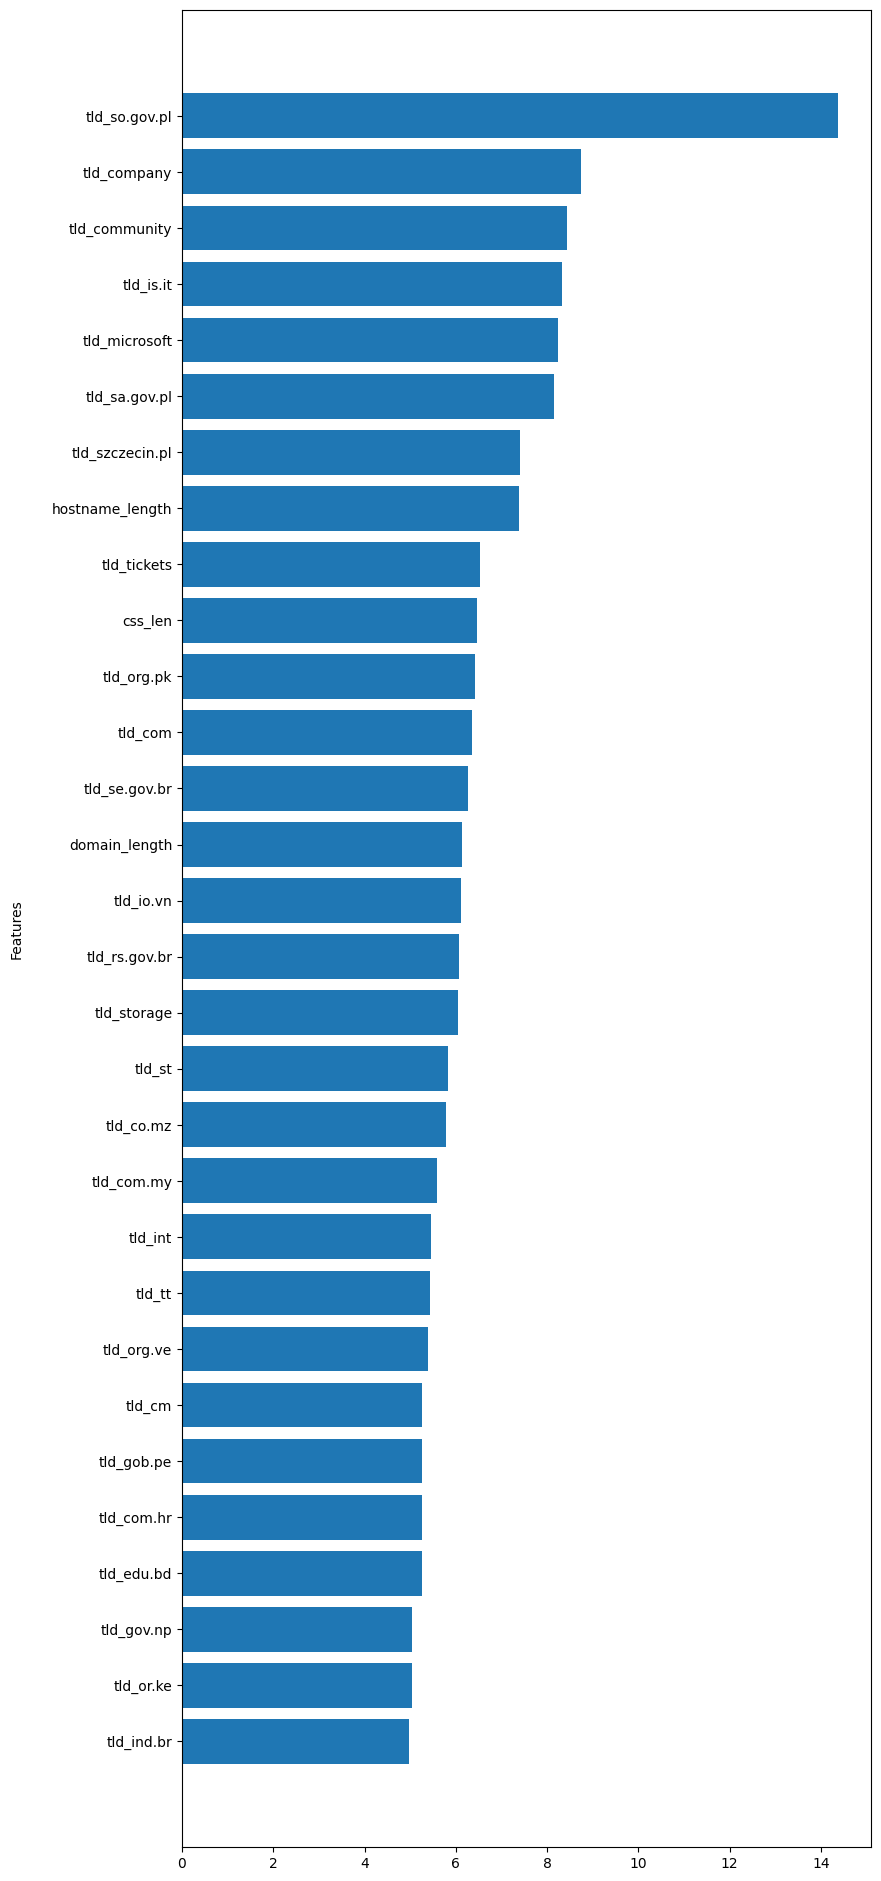

In [7]:
INPUT_FILE = "all_features.csv"
OUTPUT_GRAPH_FILE = "logistic_regression_all_features.png"
df = pd.read_csv(INPUT_FILE)

df['registrar'] = column_adjustor(df['registrar'])
df['ip_locations'] = column_adjustor(df['ip_locations'])
df = df.drop(columns=['ip_address'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

def get_top_n(string, n):
    return ' '.join([tup[0] for tup in Counter(' '.join(string.splitlines())).most_common(n)])

def len_skip_na(s):
    if type(s) != str:
        return 0
    return len(s)

ft_model = ft.load_model('./wiki.en.bin')
cols_to_vectorize = []
cols_to_binarize = []
cols_to_categorize = ['tld']
cols_to_omit = ['label', 'url']
LONG_THRESHOLD = 50

new_df = pd.DataFrame()

for colname in df.columns:
    if colname in cols_to_vectorize:
        arr = [np.mean(ft_model.get_sentence_vector(' '.join(value.splitlines()))) if not pd.isna(value) else pd.NA for value in df[colname]]
        arr = np.array(arr)
        new_df[colname] = arr
    elif colname in cols_to_binarize:
        new_df[colname] = label_binarize(df[colname], classes=pd.unique(df[colname]))
    else:
        if colname not in cols_to_omit:
            new_df[colname] = df[colname].values

X = new_df
X['tld'] = X['tld'].astype(str).fillna("Unknown")
X = X.fillna(-1)
y = df['label'].astype(float)
target = y 

numeric_cols = [col for col in new_df.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X_transformed = preprocessor.fit_transform(X)
X_transformed = X_transformed
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=42)

parameters = {'C': [0.1, 1, 10]}
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
clf = GridSearchCV(lr, parameters, verbose=3)
clf.fit(X_train, y_train)
lr = clf.best_estimator_

coef = lr.coef_[0]
f_i = list(zip(features, np.abs(coef)))
f_i.sort(key=lambda x : x[1])
f_i = f_i[-31:-1]
plt.figure(figsize=(10, 20))
plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.ylabel("Features", labelpad=20)
plt.tight_layout(pad = 5.0)
plt.savefig(OUTPUT_GRAPH_FILE)
selected_features = [feature[0] for feature in f_i]
print(f"Selected Features: {str(selected_features)}")